# Reprojecting Soil Geochemistry Data in Alaska

The data for this notebook was downloaded from the USGS at https://mrdata.usgs.gov/ngdb/soil/. You can download a shapefile to begin with, but sometimes it is more fun to roll your own shapefiles in Python. We will use `pandas` for data management, `geopandas` for geodata management, `shapely` for creating geographic points, `contextily` for plotting on a basemap, and `matplotlib` for plotting.

In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import contextily as ctx

import matplotlib.pyplot as plt
%matplotlib inline

First read in the `main.csv` file that contains locations and a bunch of other features

In [2]:
data = pd.read_csv(r'main.csv')

In this file the `'long_wgs84'` is our x-coordinate, and `'lat_wgs84'` is our y-coordinate. If you look at the data columns with `data.head()` you can see what each column contains and figure out which column contains which coordinates.

We use our coordinates to make a list that we then call as our geometry object when we create the dataframe. Here we are using the EPSG 4326 which is the WGS 84 world mercator

In [3]:
#create our geometry list from the latitude and longitude
geometry = [Point(xy) for xy in zip(data.long_wgs84, data.lat_wgs84)]
#drop our columns that we no longer need
data = data.drop(['long_wgs84', 'lat_wgs84'], axis=1)
#set our CRS dictionary
crs = {'init': 'epsg:4326'}
#one line call to create our GeoDataFrame
gdf = gpd.GeoDataFrame(data, crs=crs, geometry=geometry)

Next we read in `bestvalue.csv` that contains the geochemistry data

In [4]:
chemistry = pd.read_csv(r'bestvalue.csv')

In [5]:
chemistry.head() #quick inspection of the data

,rec_id,lab_id,species,unit,qvalue,amethod,summary,parameter,mthd_parameter
0,407,D154623,B,ppm,-20.0,ES_SQ,"-20, ES_SQ",B_ppm,B_Mthd
1,408,D154624,B,ppm,-20.0,ES_SQ,"-20, ES_SQ",B_ppm,B_Mthd
2,409,D154625,B,ppm,-20.0,ES_SQ,"-20, ES_SQ",B_ppm,B_Mthd
3,410,D154626,B,ppm,20.0,ES_SQ,"20, ES_SQ",B_ppm,B_Mthd
4,411,D154627,B,ppm,30.0,ES_SQ,"30, ES_SQ",B_ppm,B_Mthd


Now we want to combine the geochemistry data with the location data, so we use `gdf.merge()` and we merge on the `lab_id` column. You will need at least one similar column to merge the datasets. Here we are lucky that the `lab_id` correlates the sample to the geochemistry results. Also, `qvalue` is the elemental concentration value for the `species` (element), and the `unit` is the concentration (usually parts per million or percent). When there are negative `qvalue` values, that means the value was less than the detection limit for the analysis (I learned all this by reading the USGS soil website metadata)

In [6]:
combinedDF = gdf.merge(chemistry, on='lab_id') 

Let's look at the new `combinedDF` and see how things plot up spatially

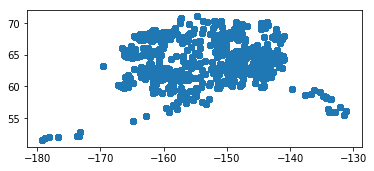

In [7]:
combinedDF.plot() #a bit slow with 148,441 points to plot

Looks a bit squashed, let's go ahead and reproject to the Alaska Albers projection EPSG 3338 and see what it looks like

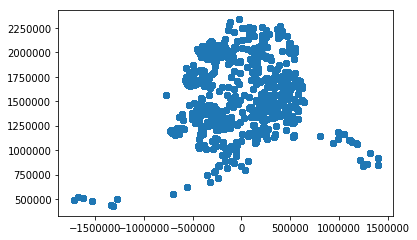

In [8]:
projectedDF = combinedDF.to_crs({'init':'epsg:3338'})
projectedDF.plot() #looks much better, more like we would expect

With the last bit of this notebook let's look at cobalt concentration in the data, so we will select the entries with `Co` from the `species` column and create a new `GeoDataFrame` 

In [9]:
cobalt = projectedDF[projectedDF['species']=='Co']

Then we will use some boilerplate code from `geopandas` and `contextily` to drop the data on a basemap http://geopandas.org/gallery/plotting_basemap_background.html

In [10]:
#this cell creates a function that grabs the stamen terrain tiles
def add_basemap(ax, zoom, url='http://tile.stamen.com/terrain/tileZ/tileX/tileY.png'):
    xmin, xmax, ymin, ymax = ax.axis()
    basemap, extent = ctx.bounds2img(xmin, ymin, xmax, ymax, zoom=zoom, url=url)
    ax.imshow(basemap, extent=extent, interpolation='bilinear')
    # restore original x/y limits
    ax.axis((xmin, xmax, ymin, ymax))

Text(0.5, 1.0, 'Soil Concentration of Cobalt (ppm)')

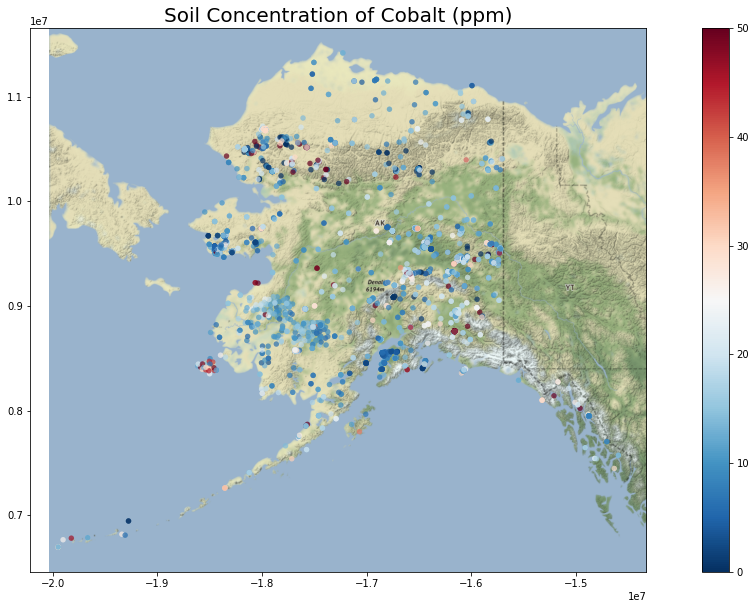

In [11]:
c2 = cobalt.to_crs(epsg=3857) #reproject the data again to align with the basemap
ax = c2.plot(column='qvalue',vmin=0, vmax=50, figsize=(20,10), legend=True, cmap='RdBu_r', alpha=0.7, edgecolor='none', markersize=30)
#plot the cobalt data, column is qvalue to get the concentration of cobalt, set our min and max
#for the colorbar, and set our figuresize. We also add a legend and use the inferno color map
add_basemap(ax, zoom=5) #add our basemap to the plot
plt.title('Soil Concentration of Cobalt (ppm)', fontsize=20)

This notebook is licensed as CC-BY, use and share to your hearts content.